<div style="width: 100%; clear: both;">
  <div style="float: left; width: 50%;">
    <img src="https://brandemia.org/sites/default/files/sites/default/files/uoc_nuevo_logo.jpg" align="left" style="width: 80%;">
  </div>
  <div style="float: right; width: 50%; text-align: right;">
    <h3 style="text-align: left; font-weight: bold;">Optimización del sistema de bicicletas compartidas en la ciudad de Valencia.</h3>
    <p style="text-align: left; font-weight: bold; font-size: 100%;">Análisis predictivo, rutas de reparto para el balanceo y gestión eficiente de las estaciones.</p>
    <p style="margin: 0; text-align: right;">Jose Luis Santos Durango</p>
    <hr style="border-top: 1px solid #ccc; margin: 10px 0;">
    <p style="margin: 0; padding-top: 22px; text-align:right;">data_prediction.ipynb · M2.879 · Trabajo Final de Máster · Área 2</p>
    <p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de datos (Data science)</p>
    <p style="margin: 0; text-align:right;">Estudios de Informática, Multimedia y Telecomunicación</p>
  </div>
</div>
<div style="width:100%;">&nbsp;</div>

# Predicción de estaciones que necesitarán ser atendidas por el camión de reparto. 

### Optimización de la ruta de reparto para una gestión más eficiente y sostenible del sistema

En este notebook, nos dedicaremos a llevar a cabo el proceso de predicción de la variable "bikes" o en su defecto el estado de la estación en un momento determinado del tiempo, con el objetivo de gestionar eficientemente el sistema, en situaciones de alta ocupación de bicicletas o escasez de espacios de estacionamiento disponibles. Para lograr este propósito, estableceremos nuestros criterios de atención de las estaciones de la siguiente manera: consideraremos que una estación presenta una alta ocupación si el 95% o más de sus espacios de estacionamiento se encuentran ocupados, y que presenta una baja disponibilidad de bicicletas si el porcentaje de bicicletas respecto al total de espacios de estacionamiento de la estación es igual o inferior al 5%.


1. [Elección de los atributos y codificación de las variables categóricas. Escalado de las características](#1)
        1.1 Elección de los atributos
        1.2 Codificación de variables categóricas
        1.3 Escalado de las características
2. [División de los datos para la predicción de los modelos](#2)
        2.1 Conjuntos de entrenamiento y testeo
            2.1.1 Conjuntos que comparten estaciones: train_data_1, test_data_1
            2.1.2 Conjuntos con estaciones dispares: train_data_2, test_data_2
3. [Modelos predictivos](#3)
        3.1 Entrenamiento de los modelos sobre los conjuntos de datos estratificados.
            3.1.1 Regresión multipolinomial
            3.1.2 Regresión logística
            3.1.3 Árboles de decisión
            3.1.4 Bosques aleatorios de árboles de decisión
        3.2 Entrenamiento de los modelos con las características de una serie temporal: horas previas.
            3.2.1 Bosques aleatorios de árboles de regresión
            3.2.2 Bosques aleatorios de árboles de clasificación
4. [Optimización de la ruta de reparto](#4)
        4.1 Predicción de los datos para la variable: precisa_balanceo. Preparación de los datos
        4.2 Elección de los horarios de reparto de camiones
        4.3 Optimización de la ruta de reparto. Algoritmo de Dijkstra

In [1]:
# pip install codecarbon

In [2]:
# import ceil
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
from scipy.spatial import distance_matrix
import folium
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split, StratifiedKFold,  RandomizedSearchCV
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from IPython.display import display
import time
from codecarbon import EmissionsTracker


#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
#import json

#import requests
#from shapely.geometry import Polygon, Point, MultiPolygon
#from pathlib import Path

<a id='1'></a>
## 1. Elección de los atributos y codificación de las variables categóricas. Escalado de las características

### 1.1 Elección de los atributos

Para poder predecir cuándo una estación necesitará ser atendida por el camión de reparto según nuestros criterios, es importante elegir las variables que tendrán impacto para la predicción. Basándonos en el conjunto de datos resultante, tenemos las siguientes variables.

### Variables numéricas

- **bike_stands**: la cantidad total de espacios de estacionamiento para bicicletas podría ser un predictor importante para determinar la demanda de bicicletas. Hay estaciones que al tener un mayor número de aparcamientos no suelen tener problemas de abastecimiento.
- **Variables Meteorológicas**: velocidad_del_viento, temperatura, humedad_relativa, precipitacion, radiacion, no2.
- **station_id, lat, lng**: son variables numéricas que indican la estación en cuestión. Solo incluiremos el ID de la estación en el desarrollo de los modelos, o en su defecto características de las estaciones.


### Variables para escalar

Dado que los datos de algunas variables numéricas pueden tener una escala mucho mayor que el resto de variables, vamos a escalarlos para que su impacto no sea tan significativo en la decisión de los modelos.

- **precio_euros_m2**: puede tener impacto en el uso de la bicicleta el nivel socieconómico de los barrios donde se localizan las estaciones.
- **close_green_area_shape**: esta variable también tenemos que escalarla para evitar modelos sesgados.
- **total_trips**: la afluencia que tiene una estación en cuanto a las bicicletas que entran y salen, también es importante a la hora de predecir las bicicletas de una estación. Una estación con mayor afluencia de viajes puede presentar mayores probelmas de abastecimiento.

### Variables categóricas a codificar

Algunos modelos necesitan que las variables sean numéricas, por lo que vamos a codificar las variables categóricas que queramos incluir en el modelo.

- barrio
- distrito
- dia_semana
- festivo


In [3]:
# load the dataset with all features
df = pd.read_csv('data_final/data_TFM.csv')
df['hora'] = pd.to_datetime(df['timestamp']).dt.hour

variables_selected = ['station_id','bike_stands','total_trips','hora','dia','mes',
                      'velocidad_del_viento','temperatura','humedad_relativa','precipitacion','radiacion','no2',
                      'precio_2022_euros_m2','close_green_area_shape',
                      'barrio','distrito','dia_semana','festivo','timestamp','bikes','bikes_avg']

df = df[variables_selected]

# adding a variable about ocupation/availability in a station
parameter = 0.95
df['precisa_balanceo'] = df.apply(lambda row: row['bikes'] >= parameter * row['bike_stands'] or row['bikes'] <= (1-parameter) * row['bike_stands'], axis=1)


df.head()

,station_id,bike_stands,total_trips,hora,dia,mes,velocidad_del_viento,temperatura,humedad_relativa,precipitacion,...,precio_2022_euros_m2,close_green_area_shape,barrio,distrito,dia_semana,festivo,timestamp,bikes,bikes_avg,precisa_balanceo
0,101,30,2.0,9,8,3,0.7,26.4,79.0,0.0,...,2094.0,246.516198,CABANYAL-C,POBLATS MARITIMS,Monday,False,2021-03-08 09:00:00,16.0,14.466667,False
1,110,30,0.0,5,3,2,4.9,11.9,85.0,0.0,...,2566.0,700.942019,LA CARRASC,ALGIROS,Wednesday,False,2021-02-03 05:00:00,11.0,10.000000,False
2,110,30,1.0,22,10,5,2.0,21.1,61.0,0.0,...,2566.0,700.942019,LA CARRASC,ALGIROS,Monday,False,2021-05-10 22:00:00,7.0,5.333333,False
3,110,30,6.0,8,17,5,1.7,19.1,79.0,0.0,...,2566.0,700.942019,LA CARRASC,ALGIROS,Monday,False,2021-05-17 08:00:00,14.0,15.233333,False
4,110,30,1.0,6,18,5,0.2,16.8,90.0,0.0,...,2566.0,700.942019,LA CARRASC,ALGIROS,Tuesday,False,2021-05-18 06:00:00,14.0,13.083333,False


### 1.2 Codificación de variables categóricas

In [4]:
# factorization for categoric varaibles
df['barrio_encoded'], _ = pd.factorize(df['barrio'])
df['distrito_encoded'], _ = pd.factorize(df['distrito'])
df['dia_semana_encoded'], _ = pd.factorize(df['dia_semana'])
df['festivo_encoded'], _ = pd.factorize(df['festivo'])

df.head()

,station_id,bike_stands,total_trips,hora,dia,mes,velocidad_del_viento,temperatura,humedad_relativa,precipitacion,...,dia_semana,festivo,timestamp,bikes,bikes_avg,precisa_balanceo,barrio_encoded,distrito_encoded,dia_semana_encoded,festivo_encoded
0,101,30,2.0,9,8,3,0.7,26.4,79.0,0.0,...,Monday,False,2021-03-08 09:00:00,16.0,14.466667,False,0,0,0,0
1,110,30,0.0,5,3,2,4.9,11.9,85.0,0.0,...,Wednesday,False,2021-02-03 05:00:00,11.0,10.000000,False,1,1,1,0
2,110,30,1.0,22,10,5,2.0,21.1,61.0,0.0,...,Monday,False,2021-05-10 22:00:00,7.0,5.333333,False,1,1,0,0
3,110,30,6.0,8,17,5,1.7,19.1,79.0,0.0,...,Monday,False,2021-05-17 08:00:00,14.0,15.233333,False,1,1,0,0
4,110,30,1.0,6,18,5,0.2,16.8,90.0,0.0,...,Tuesday,False,2021-05-18 06:00:00,14.0,13.083333,False,1,1,2,0


In [5]:
# get the codes for weekdays (will need in optimization route)
df_weekday = df[['dia_semana_encoded', 'dia_semana']].drop_duplicates()

# map the code with spanish weekday
day_map_spanish = {
    0: 'lunes',
    1: 'martes',
    2: 'miércoles',
    3: 'jueves',
    4: 'viernes',
    5: 'sábado',
    6: 'domingo'
}

# Get spanish names for weekdays
df_weekday['dia_semana'] = df_weekday['dia_semana_encoded'].map(day_map_spanish)


In [6]:
# Fill NaN values for the prediction models
df.fillna(0, inplace=True)

# Adjust the proper data types
df['total_trips'] = df['total_trips'].astype(int)
df['bikes'] = df['bikes'].astype(int)

# Only 2 decimals needed
df['velocidad_del_viento'] = df['velocidad_del_viento'].round(2)
df['bikes_avg'] = df['bikes_avg'].round(2)
df['temperatura'] = df['temperatura'].round(2)
df['humedad_relativa'] = df['humedad_relativa'].round(2)
df['precipitacion'] = df['precipitacion'].round(2)
df['radiacion'] = df['radiacion'].round(2)
df['no2'] = df['no2'].round(2)
df['precio_2022_euros_m2'] = df['precio_2022_euros_m2'].round(2)
df['close_green_area_shape'] = df['close_green_area_shape'].round(2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166364 entries, 0 to 166363
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   station_id              166364 non-null  int64  
 1   bike_stands             166364 non-null  int64  
 2   total_trips             166364 non-null  int64  
 3   hora                    166364 non-null  int64  
 4   dia                     166364 non-null  int64  
 5   mes                     166364 non-null  int64  
 6   velocidad_del_viento    166364 non-null  float64
 7   temperatura             166364 non-null  float64
 8   humedad_relativa        166364 non-null  float64
 9   precipitacion           166364 non-null  float64
 10  radiacion               166364 non-null  float64
 11  no2                     166364 non-null  float64
 12  precio_2022_euros_m2    166364 non-null  float64
 13  close_green_area_shape  166364 non-null  float64
 14  barrio              

###  1.3 Escalado de las características

Para saber las variables a escalar, vamos a ver los rangos de cada variable.

In [7]:
# Select only the numeric variables
numeric_variables = ['station_id', 'bike_stands', 'total_trips', 'hora', 'dia', 'mes', 'velocidad_del_viento', 
                     'temperatura', 'humedad_relativa', 'precipitacion', 'radiacion', 'no2', 
                     'precio_2022_euros_m2', 'close_green_area_shape']

# Calculate the maximum and minimum values of each numeric variable
maximums = df[numeric_variables].max()
minimums = df[numeric_variables].min()

# Display the results
df_resultados = pd.DataFrame({
    'Variable': numeric_variables,
    'Valor Mínimo': minimums.values,
    'Valor Máximo': maximums.values
})

df_resultados

,Variable,Valor Mínimo,Valor Máximo
0,station_id,14.0,240.00
1,bike_stands,20.0,40.00
2,total_trips,0.0,560.00
3,hora,0.0,23.00
4,dia,1.0,31.00
5,mes,1.0,12.00
6,velocidad_del_viento,0.1,15.80
7,temperatura,0.7,36.80
8,humedad_relativa,13.0,100.00
9,precipitacion,0.0,37.60


#### Estudio de dispersión de las variables: total_trips, radiacion

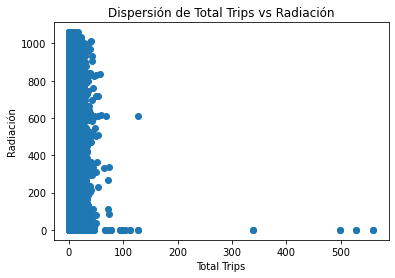

In [8]:
# total_trips, radiacion
plt.scatter(df['total_trips'], df['radiacion'])
plt.xlabel('Total Trips')
plt.ylabel('Radiación')
plt.title('Dispersión de Total Trips vs Radiación')
plt.show()

Tomamos la decisión de no escalar los datos de las variables total_trips y radiacion. Solo se escalarán los datos de las variables precio_2022_euros_m2 y close_green_area_shape. Puesto que son números bastante grandes pero que necesariamente no siguen una distribución normal, elegiremos el escalado por el min-max.

In [9]:
# define the scaler
scaler_minmax = MinMaxScaler()

# create the new variables scaled
df['precio_2022_euros_m2_scaled'] = scaler_minmax.fit_transform(df[['precio_2022_euros_m2']])
df['close_green_area_shape_scaled'] = scaler_minmax.fit_transform(df[['close_green_area_shape']])

# scaled variables display
maximums = df[['precio_2022_euros_m2_scaled','close_green_area_shape_scaled']].max()
minimums = df[['precio_2022_euros_m2_scaled','close_green_area_shape_scaled']].min()

# Display the results
df_resultados = pd.DataFrame({
    'Variable': ['precio_2022_euros_m2_scaled','close_green_area_shape_scaled'],
    'Valor Mínimo': minimums.values,
    'Valor Máximo': maximums.values
})

df_resultados

,Variable,Valor Mínimo,Valor Máximo
0,precio_2022_euros_m2_scaled,0.0,1.0
1,close_green_area_shape_scaled,0.0,1.0


<a id='2'></a>
## 2. División de los datos para la predicción de los modelos. Estratificación
### 2.1 Conjuntos de entrenamiento y testeo

A la hora de realizar la división del conjunto de datos para entrenar los distintos modelos, es muy importante tener en cuenta las siguientes cuestiones que van a ser fundamentales para desarrollar modelos no sesgados:

- Los datos que disponemos son temporales. Tenemos información de las estaciones de bicicletas para cada día y hora de 2021, y también información de las condiciones climatológicas por hora. Si los datos de un día y hora en concreto se incluyen en el conjunto de entrenamiento, se deben incluir los datos de todas las estaciones para ese mismo día y hora, para evitar tener datos climatológicos repetidos en los conjuntos de entrenamiento y testeo.

- Al incluir datos del clima, estamos hablando de datos estacionales. Es importante que se incluyan datos para el entrenamiento de todas las estaciones del año, ya que no es lo mismo la climatología en verano que en invierno. Además hay que tener en cuenta que no es lo mismo un día de fin de semana que un día de diario.

- Los datos también son espaciales. En el caso de que se incluyan en los conjuntos de entrenamiento y test, datos de las mismas estaciones, las variables que dependen de la geoposición de las estaciones (zonas verdes, precio del metro cuadrado, latitud, longitud, barrio, distrito) también van a aparecer de forma repetida.

Para poder lograr una división insesgada de los datos, vamos a aplicar las siguientes técnicas:


- Estratificación: queremos tener de forma equilibrada los datos de las distintas estaciones climatológicas (meses), de los días de la semana y de los festivos. Es decir queremos una estratificaión temporal-estacionaria. Además, para evitar el sesgo en las cuestiones de localización, como tratamos con datos espaciales queremos valorar la posibilidad de elegir distintas estaciones de bicicletas entre los conjuntos de entrenamiento y de testeo.

Luego queremos aplicar estratificación sobre una serie temporal para poder asegurar que haya:

- Proporciones equilibradas de cada mes del año (resolvemos así el problema de la estacionalidad de los datos).  
- Proporciones equilibradas en los festivos = True. 
- Proporciones equilibradas en los dia_semana.

Además, se van a definir dos tipos de conjuntos: conjuntos con estaciones comunes entre testeo y entrenamiento y conjuntos con estaciones dispares entre testeo y entrenamiento. De este modo tenemos que:

1. Conjunto de datos que comparten estaciones entre train y test (train_data_1 y test_data_1):
- Ventajas:
    - Permite al modelo capturar características específicas de cada estación, lo que podría mejorar la precisión de las predicciones para esas estaciones específicas.
    - Ayuda a evaluar cómo el modelo se desempeña en datos de estaciones similares a las que ha visto durante el entrenamiento.
- Desventajas:
    - Existe el riesgo de sobreajuste si hay una variabilidad considerable entre las estaciones.
    - La capacidad del modelo para generalizar a nuevas estaciones puede ser limitada.
2. Conjunto de datos sin compartir estaciones entre train y test (train_data_2 y test_data_2): las estaciones del conjunto de entrenamiento, serán filtradas de modo que el 20% de las estaciones no estén en entrenamiento pero sí en testeo.
- Ventajas:
    - Evitas que el modelo aprenda características específicas de una estación en particular, lo que podría llevar a una mejor generalización a nuevas estaciones.
    - Ayuda a evaluar la capacidad del modelo para capturar patrones temporales y climáticos de manera más general.
- Desventajas:
    - Si las estaciones tienen características únicas que afectan significativamente a la variable objetivo (precisa_balanceo o bikes), el modelo podría no capturar adecuadamente estas variaciones.
    - La generalización del modelo a nuevas estaciones puede ser menos precisa.

#### 2.1.1 Conjuntos que comparten estaciones: train_data_1, test_data_1

In [10]:
# Create a DataFrame with all unique timestamp records
unique_timestamps = df['timestamp'].unique()
timestamps_df = pd.DataFrame({'timestamp': unique_timestamps})

# Combine with relevant variables for stratification: dia_semana, month, and festivo
timestamps_df = timestamps_df.merge(df[['timestamp', 'dia_semana_encoded', 'mes', 'festivo_encoded']], on='timestamp').drop_duplicates()

# Stratified split of timestamps into training and testing sets
train_timestamps, test_timestamps = train_test_split(timestamps_df, test_size=0.2, random_state=42, 
                                                     stratify=timestamps_df[['dia_semana_encoded', 
                                                                             'mes', 
                                                                             'festivo_encoded']])

# Filter original data based on train and test timestamps
train_data_1 = df[df['timestamp'].isin(train_timestamps['timestamp'])]
test_data_1 = df[df['timestamp'].isin(test_timestamps['timestamp'])]

Veamos si efectivamente la estratificación ha funcionado de forma correcta y tenemos los mismo porcentajes (o similares) para cada una de las clases de nuestra variables: mes, dia_semana y festivo, en los conjuntos de entrenamiento y testeo.

In [11]:
# Funtion for calculate the percentages
def calculate_percentage(data, column):
    counts = data[column].value_counts(normalize=True).sort_index()
    return counts * 100

# weekday
train_percentage_dia_semana = calculate_percentage(train_data_1, 'dia_semana')
test_percentage_dia_semana = calculate_percentage(test_data_1, 'dia_semana')

# month
train_percentage_mes = calculate_percentage(train_data_1, 'mes')
test_percentage_mes = calculate_percentage(test_data_1, 'mes')

# festivo
train_percentage_festivo = calculate_percentage(train_data_1, 'festivo')
test_percentage_festivo = calculate_percentage(test_data_1, 'festivo')

# display the data
dia_semana_percentage_df = pd.DataFrame({'Train Data': train_percentage_dia_semana, 
                                    'Test Data': test_percentage_dia_semana})
mes_percentage_df = pd.DataFrame({'Train Data': train_percentage_mes, 
                                   'Test Data': test_percentage_mes})
festivo_percentage_df = pd.DataFrame({'Train Data': train_percentage_festivo, 
                                      'Test Data': test_percentage_festivo})

display(dia_semana_percentage_df, mes_percentage_df, festivo_percentage_df)

,Train Data,Test Data
Friday,14.503926,14.620217
Monday,14.232691,14.277556
Saturday,14.246966,14.277556
Sunday,14.246966,14.163335
Thursday,14.261242,14.220445
Tuesday,14.246966,14.220445
Wednesday,14.261242,14.220445


,Train Data,Test Data
1,8.479657,8.566533
2,7.694504,7.595660
3,8.479657,8.509423
4,8.208423,8.280982
5,8.508208,8.452313
6,8.208423,8.223872
7,8.493933,8.452313
8,8.508208,8.452313
9,8.222698,8.223872
10,8.479657,8.509423


,Train Data,Test Data
False,95.931478,95.716733
True,4.068522,4.283267


#### 2.1.2 Conjuntos con estaciones dispares: train_data_2, test_data_2

Podemos ver que efectivamente se ha conseguido tener los dos conjuntos de forma equilibrada, por lo tanto ya solo nos queda decidir las estaciones que se eliminarán del entrenamiento y se conservarán en testing para formar los otros dos pares de conjuntos. Siguiendo la clasificación realizada en el notebook data_analysis.ipynb de las estaciones:

- Barrios del extraradio de Valencia: 217, 240, 188, 167
- Zona de estudiantes: 85, 92, 97, 110, 114
- Zona residencial: 79, 75, 66, 101, 50, 41 (esta última se añade por ser la estación que corresponde a mi residencia).
- Zonas turísticas y de ocio: 14, 148, 40, 28, 149

Elegiremos una estación de cada uno de estos grupos para eliminarla del conjunto de entrenamiento.

In [12]:
# train and test datasets without station_id in comoon
train_data_2 = df[~df['station_id'].isin([217,85,79,14])]
test_data_2 = df[df['station_id'].isin([217,85,79,14])]

<a id='3'></a>
## 3. Modelos predictivos

En este apartado vamos a trabajar los distintos modelos supervisados con el objetivo de estimar el número de bicicletas que tendrá una estación determinada en una hora concreta en función de las variables que hemos estado trabajando. Sin embargo, no nos interesa únicamente el número exacto de las bicicletas de que tendrá una estación determinada en un momento específico, lo que realmente nos interesa saber es cuándo una estación tendrá necesidad de ser balanceada por tener una alta ocupación o una baja disponibilidad de bicicletas. Por este motivo vamos a elegir distintos tipos de modelos para poder lograr nuestro objetivo, y en función de los resultados obtenidos en la evaluación de los modelos vamos a intentar elegir el modelo que mejor se ajusta a la situación y que facilitará el balanceo del sistema. Clasificamos así nuestros modelos en:

- Modelos de regresión para la estimación del valor medio de bicicletas por hora
- Modelos de clasificación para la variable precisa_balanceo.

Para entrenar los modelos usaremos 4 experimentos de partición de los datos:

- Separación de los datos de forma estratificada con estaciones conjuntas para entrenamiento y testeo.
- Separación de los datos de forma estratificada con estaciones dispares para entrenamiento y testeo.
- Serie temporal: separación en conjuntos 8020 teniendo en cuenta los valores del campo bikes de horas anteriores.
- Serie temporal con estratificación: aplicamos estratificación sobre los datos que contienen el valor de las bicicletas en horas anteiores.

### 3.1 Entrenamiento de los modelos sobre los conjuntos de datos estratificados.

Los distintos modelos de regresión que vamos a desarrollar son los siguientes:

- Modelo de regresión multipolinomial para determinar el valor de bicicletas medias por hora (bikes_avg).
- Modelo de regresión logística que indica cuando una estación va a tener más del 95% de sus bornetas ocupadas o menos de un 5% de bicicletas disponibles.
- Árboles de decisión para evaluar si una estación necesita atención al superar los parámetros establecidos.
- Bosques aleatorios de árboles de decisión.

### 3.1.1 Regresión multipolinomial

La primera prueba que vamos a realizar será un modelo de regresión multipolinomial para ver cómo funciona a la hora de estimar el valor medio de bicicletas que tiene cada estación. No podemos estimar el valor de bicicletas exactas, ya que es una variable discreta, por eso vamos a estimar el valor medio y veamos cómo se comporta el modelo en función de los grados del polinomio.

In [13]:
# multipolinomial regression features and target
features = ['hora', 'mes', 'dia_semana_encoded', 'festivo_encoded',
            'total_trips', 'velocidad_del_viento', 'temperatura', 
            'humedad_relativa', 'precipitacion', 'radiacion', 'no2', 
            'precio_2022_euros_m2_scaled', 'close_green_area_shape_scaled', 'bike_stands']
target = 'bikes_avg'


# train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, degree):
    """
    Trains a polynomial regression model and evaluates it using the test set.

    Input Parameters:
    X_train : array-like, shape (n_samples, n_features)
        Training samples.

    y_train : array-like, shape (n_samples,)
        Target values corresponding to X_train.

    X_test : array-like, shape (n_samples, n_features)
        Test samples.

    y_test : array-like, shape (n_samples,)
        Target values corresponding to X_test.

    degree : int
        The degree of the polynomial to use in polynomial regression.

    Returns:
    mse : float
        Mean Squared Error of the model predictions on the test set.

    r2 : float
        R^2 coefficient of determination of the model predictions on the test set.
    """
    # Initialize the polynomial regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, r2

# degrees for polynomial equation
degrees = [1, 2, 3]

# iterate over the data and different degrees
for i, (train_data, test_data) in enumerate([(train_data_1, test_data_1), (train_data_2, test_data_2)], start=1):
    print(f"Resultados para data_{i}:")
    for degree in degrees:
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        
        # Initialize CarbonTracker
        tracker = EmissionsTracker(log_level='error')
        tracker.start()
        
        start_time = time.time()
        mse, r2 = train_and_evaluate_model(X_train, y_train, X_test, y_test, degree)
        end_time = time.time()
        
        # Stop CarbonTracker
        emissions: float = tracker.stop()
        
        # Print results
        print(f"Error cuadrático medio (MSE) para test_data_{i} con polinomio de grado {degree}: {mse}")
        print(f"Coeficiente de determinación para data_{i} con polinomio de grado {degree}: {r2}")
        
        # Print execution time and CO2 emissions
        print(f"Tiempo de ejecución: {end_time - start_time} segundos")
        print(f"Emisiones de CO2: {emissions} kgCO2")


Resultados para data_1:
Error cuadrático medio (MSE) para test_data_1 con polinomio de grado 1: 55.490188786838566
Coeficiente de determinación para data_1 con polinomio de grado 1: 0.14175441936103728
Tiempo de ejecución: 0.06207990646362305 segundos
Emisiones de CO2: 3.030212524175644e-08 kgCO2
Error cuadrático medio (MSE) para test_data_1 con polinomio de grado 2: 51.67505347711325
Coeficiente de determinación para data_1 con polinomio de grado 2: 0.20076166173481025
Tiempo de ejecución: 0.49701809883117676 segundos
Emisiones de CO2: 2.4038644284486773e-07 kgCO2
Error cuadrático medio (MSE) para test_data_1 con polinomio de grado 3: 42.00476863848221
Coeficiente de determinación para data_1 con polinomio de grado 3: 0.3503282681516111
Tiempo de ejecución: 5.0118279457092285 segundos
Emisiones de CO2: 2.4219721980977057e-06 kgCO2
Resultados para data_2:
Error cuadrático medio (MSE) para test_data_2 con polinomio de grado 1: 48.230967311630906
Coeficiente de determinación para data_2 

### 3.1.2 Regresión logística

In [14]:
# logistic regression to predict the target: precisa_balanceo
features = ['hora', 'mes', 'dia_semana_encoded', 'festivo_encoded',
            'total_trips', 'velocidad_del_viento', 'temperatura', 
            'humedad_relativa', 'precipitacion', 'radiacion', 'no2', 
            'precio_2022_euros_m2_scaled', 'close_green_area_shape_scaled', 'bike_stands']

target = 'precisa_balanceo'

# train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    """
    Trains a logistic regression model and evaluates it using the test set.

    Input Parameters:
    X_train : array-like, shape (n_samples, n_features)
        Training samples.

    y_train : array-like, shape (n_samples,)
        Target labels corresponding to X_train.

    X_test : array-like, shape (n_samples, n_features)
        Test samples.

    y_test : array-like, shape (n_samples,)
        Target labels corresponding to X_test.

    Returns:
    accuracy : float
        Accuracy of the model predictions on the test set.

    y_pred : array-like, shape (n_samples,)
        Predicted labels on the test set.

    conf_matrix : array-like, shape (n_classes, n_classes)
        Confusion matrix of the model predictions on the test set.

    class_report : string
        Text summary of the precision, recall, F1-score, and support of the model predictions on the test set.
    """
    # Inicializar el modelo de regresión polinomial
    model = LogisticRegression(max_iter=1000)
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    return accuracy, y_pred, confusion_matrix, classification_report

# iterate to check the results of models
for i, (train_data, test_data) in enumerate([(train_data_1, test_data_1), (train_data_2, test_data_2)], start=1):
    print(f"Resultados para data_{i}:")
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    # Initialize CarbonTracker
    tracker = EmissionsTracker(log_level='error')
    tracker.start()
    
    start_time = time.time()
    accuracy, y_pred, conf_matrix, class_report = train_and_evaluate_model(X_train, y_train, X_test, y_test)
    end_time = time.time()
    
    # Stop CarbonTracker
    emissions: float = tracker.stop()
    
    print(f"Precisión para test_data_{i}: {accuracy}")
    print(f"Matriz de confusión para test_data_{i}:\n{conf_matrix(y_test, y_pred)}")
    print(f"Reporte de clasificación para test_data_{i}:\n{class_report(y_test, y_pred)}")
    print(f"Tiempo de ejecución: {end_time - start_time} segundos")
    print(f"Emisiones de CO2: {emissions} kgCO2")


Resultados para data_1:
Precisión para test_data_1: 0.7881511316841504
Matriz de confusión para test_data_1:
[[26221     0]
 [ 7048     0]]
Reporte de clasificación para test_data_1:
              precision    recall  f1-score   support

       False       0.79      1.00      0.88     26221
        True       0.00      0.00      0.00      7048

    accuracy                           0.79     33269
   macro avg       0.39      0.50      0.44     33269
weighted avg       0.62      0.79      0.69     33269

Tiempo de ejecución: 5.182107925415039 segundos
Emisiones de CO2: 2.5044425625360013e-06 kgCO2
Resultados para data_2:
Precisión para test_data_2: 0.7486866148926451
Matriz de confusión para test_data_2:
[[26195    39]
 [ 8763    27]]
Reporte de clasificación para test_data_2:
              precision    recall  f1-score   support

       False       0.75      1.00      0.86     26234
        True       0.41      0.00      0.01      8790

    accuracy                           0.75     

### 3.1.3 Árboles de decisión

In [15]:
# Decision Tree Classifier to predict the target: precisa_balanceo
features = ['hora', 'mes', 'dia_semana_encoded', 'festivo_encoded',
            'total_trips', 'velocidad_del_viento', 'temperatura', 
            'humedad_relativa', 'precipitacion', 'radiacion', 'no2', 
            'precio_2022_euros_m2_scaled', 'close_green_area_shape_scaled', 'bike_stands']

target = 'precisa_balanceo'

def train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test, max_depth=None, max_features='sqrt'):
    """
    Trains a decision tree classifier and evaluates it using the test set.

    Input Parameters:
    X_train : array-like, shape (n_samples, n_features)
        Training samples.

    y_train : array-like, shape (n_samples,)
        Target labels corresponding to X_train.

    X_test : array-like, shape (n_samples, n_features)
        Test samples.

    y_test : array-like, shape (n_samples,)
        Target labels corresponding to X_test.

    max_depth : int or None, default=None
        The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

    max_features : int, float, string, or None, default='sqrt'
        The number of features to consider when looking for the best split:
        - If 'sqrt', then max_features=sqrt(n_features).
        - If 'log2', then max_features=log2(n_features).
        - If None, then max_features=n_features.
        - If int, then consider max_features features at each split.

    Returns:
    accuracy : float
        Accuracy of the model predictions on the test set.

    y_pred : array-like, shape (n_samples,)
        Predicted labels on the test set.

    conf_matrix : array-like, shape (n_classes, n_classes)
        Confusion matrix of the model predictions on the test set.

    class_report : string
        Text summary of the precision, recall, F1-score, and support of the model predictions on the test set.
    """
    # Initialize the Decision Tree Classifier
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42, max_features=max_features)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    return accuracy, y_pred, conf_matrix, class_report

# Iterate to check the results of Decision Tree Classifier with different parameters
for i, train_data in enumerate([train_data_1, train_data_2], start=1):
    print(f"Results for train_data_{i}:")
    X_train = train_data[features]
    y_train = train_data[target]
    
    for max_depth in [10, 20, 30]:
        for max_features in ['sqrt']:
            print(f"Using max_depth={max_depth}, max_features={max_features}:")
            
            # Initialize CarbonTracker
            tracker = EmissionsTracker(log_level='error')
            tracker.start()
            
            start_time = time.time()
            accuracy, y_pred, conf_matrix, class_report = train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test, max_depth=max_depth, max_features=max_features)
            end_time = time.time()
            
            # Stop CarbonTracker
            emissions: float = tracker.stop()
            
            print(f"Accuracy: {accuracy}")
            print(f"Confusion Matrix:\n{conf_matrix}")
            print(f"Classification Report:\n{class_report}")
            print(f"Tiempo de ejecución: {end_time - start_time} segundos")
            print(f"Emisiones de CO2: {emissions} kgCO2")
            

Results for train_data_1:
Using max_depth=10, max_features=sqrt:
Accuracy: 0.7630481955230699
Confusion Matrix:
[[25286   948]
 [ 7351  1439]]
Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.96      0.86     26234
        True       0.60      0.16      0.26      8790

    accuracy                           0.76     35024
   macro avg       0.69      0.56      0.56     35024
weighted avg       0.73      0.76      0.71     35024

Tiempo de ejecución: 0.16820001602172852 segundos
Emisiones de CO2: 8.155616791009903e-08 kgCO2
Using max_depth=20, max_features=sqrt:
Accuracy: 0.8679476930105071
Confusion Matrix:
[[25190  1044]
 [ 3581  5209]]
Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.96      0.92     26234
        True       0.83      0.59      0.69      8790

    accuracy                           0.87     35024
   macro avg       0.85      0.78      0.80     35024

### 3.1.4 Bosques aleatorios de árboles de decisión

In [16]:
# RandomForestClassifier to predict the target: precisa_balanceo
features = ['hora', 'mes', 'dia_semana_encoded', 'festivo_encoded',
            'total_trips', 'velocidad_del_viento', 'temperatura', 
            'humedad_relativa', 'precipitacion', 'radiacion', 'no2', 
            'precio_2022_euros_m2_scaled', 'close_green_area_shape_scaled', 'bike_stands']

target = 'precisa_balanceo'

def train_and_evaluate_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None):
    """
    Trains a random forest classifier and evaluates it using the test set.

    Input Parameters:
    X_train : array-like, shape (n_samples, n_features)
        Training samples.

    y_train : array-like, shape (n_samples,)
        Target labels corresponding to X_train.

    X_test : array-like, shape (n_samples, n_features)
        Test samples.

    y_test : array-like, shape (n_samples,)
        Target labels corresponding to X_test.

    n_estimators : int, default=100
        The number of trees in the forest.

    max_depth : int or None, default=None
        The maximum depth of the trees. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

    Returns:
    accuracy : float
        Accuracy of the model predictions on the test set.

    y_pred : array-like, shape (n_samples,)
        Predicted labels on the test set.

    conf_matrix : array-like, shape (n_classes, n_classes)
        Confusion matrix of the model predictions on the test set.

    class_report : string
        Text summary of the precision, recall, F1-score, and support of the model predictions on the test set.
    """
    # Initialize the RandomForestClassifier
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1, max_features='sqrt')
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    return accuracy, y_pred, conf_matrix, class_report

# Iterate to check the results of RandomForestClassifier with different parameters
for i, train_data in enumerate([train_data_1, train_data_2], start=1):
    print(f"Results for train_data_{i}:")
    X_train = train_data[features]
    y_train = train_data[target]
    
    for n_estimators in [100,1000]:
        for max_depth in [10, 20, 30]:
            print(f"Using n_estimators={n_estimators}, max_depth={max_depth}:")
                
            
            # Initialize CarbonTracker
            tracker = EmissionsTracker(log_level='error')
            tracker.start()
            
            start_time = time.time()
            accuracy, y_pred, conf_matrix, class_report = train_and_evaluate_random_forest(X_train, y_train, X_test, y_test, n_estimators=n_estimators, max_depth=max_depth)
            end_time = time.time()
            
            # Stop CarbonTracker
            emissions: float = tracker.stop()
            
            print(f"Accuracy: {accuracy}")
            print(f"Confusion Matrix:\n{conf_matrix}")
            print(f"Classification Report:\n{class_report}")
            print(f"Tiempo de ejecución: {end_time - start_time} segundos")
            print(f"Emisiones de CO2: {emissions} kgCO2")

Results for train_data_1:
Using n_estimators=100, max_depth=10:
Accuracy: 0.7718136135221563
Confusion Matrix:
[[25918   316]
 [ 7676  1114]]
Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.99      0.87     26234
        True       0.78      0.13      0.22      8790

    accuracy                           0.77     35024
   macro avg       0.78      0.56      0.54     35024
weighted avg       0.77      0.77      0.70     35024

Tiempo de ejecución: 1.6359920501708984 segundos
Emisiones de CO2: 7.907308665120601e-07 kgCO2
Using n_estimators=100, max_depth=20:
Accuracy: 0.9253369118318867
Confusion Matrix:
[[26059   175]
 [ 2440  6350]]
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     26234
        True       0.97      0.72      0.83      8790

    accuracy                           0.93     35024
   macro avg       0.94      0.86      0.89     35024
we

### 3.2 Entrenamiento de los modelos con las características de una serie temporal: horas previas.

En este apartado vamos a generar dos grupos de conjuntos de datos para evaluar los resultados de los modelos anteriores. Al tratarse de una serie temporal, dividiremos los datos de forma ordenada, y añadiremos el valor del número de bicicletas que tiene una estación en las n horas previas. Al igual que en los experimentos anteriores, en este caso vamos a evaluar los modelos sobre dos tipos de datos:

- Conjuntos con información de horas previas y división ordenada 8020.
- Conjuntos con información de horas previas y estratificación.

Lo primero que haremos será definir las funciones que nos preparen los datos con los formatos deseados para ser imputados a los modelos predictivos.

In [17]:
def series_to_supervised(data, features, target, n_in=1, dropnan=True):
    """
    Converts a time series dataset into a supervised learning dataset.

    Input Parameters:
    data : array-like or DataFrame
        The input time series data.

    features : list of strings
        The list of feature names to be used as input features.

    target : string
        The name of the target variable.

    n_in : int, default=1
        The number of lag observations as input (X).

    dropnan : bool, default=True
        Whether or not to drop rows with NaN values after transformation.

    Returns:
    agg : DataFrame
        The supervised learning dataset.

    Notes:
    The output DataFrame will have columns representing lag observations of the target variable
    and current values of both the target variable and selected input features.
    
    Source: https://gist.github.com/kevincdurand1
    """
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    
    # Selecting only the necessary features for input and target
    selected_features = features + [target]
    df = df[selected_features]
    
    cols, names = list(), list()
    # Input features for current time (t)
    cols.append(df[features])
    names += [(f'{feat}') for feat in features]
    # Input sequence (t-1, ... t-n) for bikes_avg
    for i in range(1, n_in + 1):
        cols.append(df[target].shift(i))
        names += [(f'{target}(t-{i})')]

    # Current values of bikes_avg (t)
    cols.append(df[target])
    names += [(target)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def prepare_data(df,features,target,hours):
    """
    Prepares the data for time series forecasting by generating lagged observations for each station.

    Input Parameters:
    df : DataFrame
        The input DataFrame containing the time series data.

    features : list of strings
        The list of feature names to be used as input features.

    target : string
        The name of the target variable.

    hours : int
        The number of lag observations to generate for each station.

    Returns:
    df_final : DataFrame
        The prepared dataset with lagged observations for each station.

    Notes:
    This function generates lagged observations for each station in the dataset using the specified features
    and target variable. It sorts the dataset by timestamp, generates lagged observations using the
    `series_to_supervised` function, concatenates the resulting DataFrames, and sorts the final DataFrame by timestamp.
    """
    df_sorted = df.sort_values(by='timestamp')
    unique_station_ids = df_sorted['station_id'].unique()
    
    # Let's save the dataframes generated by series_to_supervised
    dfs_to_concat = []
    for station_id in unique_station_ids:
        data = series_to_supervised(df_sorted[df_sorted['station_id'] == station_id], features, target, n_in=hours)
        dfs_to_concat.append(data)

    # Concatenate all dataframes
    df_final = pd.concat(dfs_to_concat, ignore_index=True)
    df_final = df_final.sort_values(by='timestamp')
    return df_final


def stratification(df,features,target,hours):
    """
    Prepares the data for stratified splitting into training and testing sets.

    Input Parameters:
    df : DataFrame
        The input DataFrame containing the time series data.

    features : list of strings
        The list of feature names to be used as input features.

    target : string
        The name of the target variable.

    hours : int
        The number of lag observations used for generating the dataset.

    Returns:
    train_data_1 : DataFrame
        The training dataset for the first split (stratified based on timestamps).

    test_data_1 : DataFrame
        The testing dataset for the first split (stratified based on timestamps).

    train_data_2 : DataFrame
        The training dataset for the second split (excluding specific station_ids).

    test_data_2 : DataFrame
        The testing dataset for the second split (specific station_ids only).
    """
    
    df = prepare_data(df,features,target,hours)

    # Create a DataFrame with all unique timestamp records
    unique_timestamps = df['timestamp'].unique()
    timestamps_df = pd.DataFrame({'timestamp': unique_timestamps})

    # Combine with relevant variables for stratification: dia_semana, month, and festivo
    timestamps_df = timestamps_df.merge(df[['timestamp', 'dia_semana_encoded', 'mes', 'festivo_encoded']], on='timestamp').drop_duplicates()

    # Stratified split of timestamps into training and testing sets
    train_timestamps, test_timestamps = train_test_split(timestamps_df, test_size=0.2, random_state=42, 
                                                         stratify=timestamps_df[['dia_semana_encoded', 
                                                                                 'mes', 
                                                                                 'festivo_encoded']])
    # Filter original data based on train and test timestamps
    train_data_1 = df[df['timestamp'].isin(train_timestamps['timestamp'])]
    test_data_1 = df[df['timestamp'].isin(test_timestamps['timestamp'])]    
    
    # train and test datasets without station_id in comoon
    train_data_2 = df[~df['station_id'].isin([217,85,79,14])]
    test_data_2 = df[df['station_id'].isin([217,85,79,14])]
    
    return train_data_1,test_data_1,train_data_2,test_data_2


def split_datasets_stratification(df,features,target,hours):
    """
    Splits the prepared data into training and testing datasets for two different stratifications.

    Input Parameters:
    df : DataFrame
        The input DataFrame containing the time series data.

    features : list of strings
        The list of feature names to be used as input features.

    target : string
        The name of the target variable.

    hours : int
        The number of lag observations used for generating the dataset.

    Returns:
    X_train_1 : DataFrame
        Features for training dataset 1 (stratified based on timestamps).

    y_train_1 : Series
        Target labels for training dataset 1.

    X_test_1 : DataFrame
        Features for testing dataset 1 (stratified based on timestamps).

    y_test_1 : Series
        Target labels for testing dataset 1.

    X_train_2 : DataFrame
        Features for training dataset 2 (excluding specific station_ids).

    y_train_2 : Series
        Target labels for training dataset 2.

    X_test_2 : DataFrame
        Features for testing dataset 2 (specific station_ids only).

    y_test_2 : Series
        Target labels for testing dataset 2.
    """
    
    train_data_1,test_data_1,train_data_2,test_data_2 = stratification(df,features,target,hours)
    X_train_1 = train_data_1.drop(columns=['timestamp','station_id',target])
    y_train_1 = train_data_1[target]
    X_test_1 = test_data_1.drop(columns=['timestamp','station_id',target])
    y_test_1 = test_data_1[target]
    X_train_2 = train_data_2.drop(columns=['timestamp','station_id',target])
    y_train_2 = train_data_2[target]
    X_test_2 = test_data_2.drop(columns=['timestamp','station_id',target])
    y_test_2 = test_data_2[target]
    
    return X_train_1,y_train_1,X_test_1,y_test_1,X_train_2,y_train_2,X_test_2,y_test_2
    
    
def split_datasets_size(df,features,target,hours,train_size):
    """
    Splits the prepared data into training and testing datasets based on a specified train size.

    Input Parameters:
    df : DataFrame
        The input DataFrame containing the time series data.

    features : list of strings
        The list of feature names to be used as input features.

    target : string
        The name of the target variable.

    hours : int
        The number of lag observations used for generating the dataset.

    train_size : float
        The proportion of the dataset to include in the training split.

    Returns:
    X_train : DataFrame
        Features for the training dataset.

    y_train : Series
        Target labels for the training dataset.

    X_test : DataFrame
        Features for the testing dataset.

    y_test : Series
        Target labels for the testing dataset.

    Notes:
    This function splits the prepared data into training and testing datasets based on a specified train size.
    It utilizes the prepare_data function to generate the dataset and then splits the dataset into training and testing sets
    based on the provided train size. The features and target labels are extracted accordingly.
    """
    
    df = prepare_data(df,features,target,hours)
    X = df.drop(columns=['timestamp','station_id',target])
    y = df[target]
    split_index = int(train_size * len(df))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    return X_train,y_train,X_test,y_test


### 3.2.1 Bosques aleatorios de árboles de regresión

#### Validación cruzada y búsqueda de hiperparámetros

In [18]:
# RandomForestregressor over 8020 sets, cross validation and grid search
features = ['timestamp','station_id',
            'hora','dia','mes','dia_semana_encoded','festivo_encoded',
            'total_trips','bike_stands',
            'velocidad_del_viento','temperatura','precipitacion']
target = 'bikes_avg'

X_train,y_train,X_test,y_test = split_datasets_size(df,features,target,6,0.8)

# Cross validation for time series
tscv = TimeSeriesSplit(n_splits=3)

# Hyperparameters
param_grid = {
    'n_estimators': [100],
    'max_depth': [20,30],
    'min_samples_split': [2, 5]
}


rf = RandomForestRegressor()

# Initialize CarbonTracker
tracker = EmissionsTracker(log_level='error')
tracker.start()

# Start the search of best hyperparameters combination with cross validation
start_time = time.time()
rf_cv = RandomizedSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_iter=4)
rf_cv.fit(X_train, y_train)
search_time = time.time() - start_time

# Stop CarbonTracker
emissions: float = tracker.stop()

# Get best parameters
best_params = rf_cv.best_params_
print("Best Parameters:", best_params)
print(f"Tiempo de búsqueda de hiperparámetros: {search_time} segundos")
print(f"Emisiones de CO2 en la búsqueda: {emissions} kgCO2")


# Evaluate the model
final_model = rf_cv.best_estimator_
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio en los datos de testing:", mse)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 30}
Tiempo de búsqueda de hiperparámetros: 504.56520795822144 segundos
Emisiones de CO2 en la búsqueda: 0.00024378595472501167 kgCO2
Error cuadrático medio en los datos de testing: 4.766120747770277


#### Búsqueda del número de horas

Elegimos ahora el valor de los mejores estimadores que se ha obtenido en la ejecución anterior y buscaremos el mejor número de horas previas para encontrar el modelo más preciso.

In [19]:
# RandomForestregressor over 8020 sets, n_in parameter search

features = ['timestamp','station_id' 
            ,'hora','dia','mes','dia_semana_encoded','festivo_encoded'
            ,'total_trips','bike_stands'
            ,'velocidad_del_viento','temperatura','precipitacion'
            ,'precio_2022_euros_m2_scaled', 'close_green_area_shape_scaled'
           ]
target = 'bikes_avg'
hours = [1,2,3,6]


rf = RandomForestRegressor(
            n_estimators=100,
            criterion='mse',
            max_depth=30,
            max_features='sqrt',
            n_jobs=-1,
            random_state=42
        )

for hour in hours:
    X_train,y_train,X_test,y_test = split_datasets_size(df,features,target,hour,0.8)
    
    print(f"Considerando el número de bicicletas de las {hour} horas previas:")
                       
    # Initialize CarbonTracker
    tracker = EmissionsTracker(log_level='error')
    tracker.start()
            
    start_time = time.time()
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    
    # Metrics of evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    end_time = time.time()
            
    # Stop CarbonTracker
    emissions: float = tracker.stop()
            
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  R^2 Score: {r2:.2f}")
    print(f"  Tiempo de ejecución: {end_time - start_time} segundos")
    print(f"  Emisiones de CO2: {emissions} kgCO2")


Considerando el número de bicicletas de las 1 horas previas:
  Mean Squared Error (MSE): 5.31
  Mean Absolute Error (MAE): 1.59
  R^2 Score: 0.93
  Tiempo de ejecución: 3.1053528785705566 segundos
  Emisiones de CO2: 1.5010694885301592e-06 kgCO2
Considerando el número de bicicletas de las 2 horas previas:
  Mean Squared Error (MSE): 4.48
  Mean Absolute Error (MAE): 1.40
  R^2 Score: 0.94
  Tiempo de ejecución: 3.301912784576416 segundos
  Emisiones de CO2: 1.5958135486495496e-06 kgCO2
Considerando el número de bicicletas de las 3 horas previas:
  Mean Squared Error (MSE): 4.60
  Mean Absolute Error (MAE): 1.40
  R^2 Score: 0.94
  Tiempo de ejecución: 3.4568369388580322 segundos
  Emisiones de CO2: 1.6705000024509431e-06 kgCO2
Considerando el número de bicicletas de las 6 horas previas:
  Mean Squared Error (MSE): 4.64
  Mean Absolute Error (MAE): 1.40
  R^2 Score: 0.93
  Tiempo de ejecución: 4.9349751472473145 segundos
  Emisiones de CO2: 2.385196483217478e-06 kgCO2


#### Conjuntos estratificados con datos de las 2 horas previas

Como podemos observar, el menor error se obtienen con los datos de las dos horas previas. Vamos ahora a incluir estratificación para la partición del conjunto de datos, tal como se hizo en el apartado 3.1

In [20]:
# RandomForestRegressor with stratification and n_in=2 hours

features = ['timestamp','station_id' 
            ,'hora','dia','mes','dia_semana_encoded','festivo_encoded'
            ,'total_trips','bike_stands'
            ,'velocidad_del_viento','temperatura','precipitacion'
            ,'precio_2022_euros_m2_scaled', 'close_green_area_shape_scaled'
           ]
target = 'bikes_avg'

X_train_1,y_train_1,X_test_1,y_test_1,X_train_2,y_train_2,X_test_2,y_test_2 = \
            split_datasets_stratification(df,features,target,2)



# Define the model
rf = RandomForestRegressor(
        n_estimators=100,
        criterion='mse',
        max_depth=30,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )

# Create the dataset list
datasets = [(X_train_1, y_train_1, X_test_1, y_test_1), (X_train_2, y_train_2, X_test_2, y_test_2)]

# Iteration over the data
for i, (X_train, y_train, X_test, y_test) in enumerate(datasets):
    
    # Initialize CarbonTracker
    tracker = EmissionsTracker(log_level='error')
    tracker.start()
    
    # Fit the model
    start_time = time.time()
    rf.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf.predict(X_test)
    end_time = time.time()
    
    # Stop CarbonTracker
    emissions: float = tracker.stop()
    
    # Metrics of evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print the results
    print(f"Conjunto {i+1}:")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  R^2 Score: {r2:.2f}")
    print(f"  Tiempo de ejecución: {end_time - start_time} segundos")
    print(f"  Emisiones de CO2: {emissions} kgCO2")

Conjunto 1:
  Mean Squared Error (MSE): 3.69
  Mean Absolute Error (MAE): 1.18
  R^2 Score: 0.94
  Tiempo de ejecución: 3.4208221435546875 segundos
  Emisiones de CO2: 1.6538583109211923e-06 kgCO2
Conjunto 2:
  Mean Squared Error (MSE): 3.48
  Mean Absolute Error (MAE): 1.21
  R^2 Score: 0.88
  Tiempo de ejecución: 3.2782387733459473 segundos
  Emisiones de CO2: 1.5842171667754653e-06 kgCO2


### 3.2.2 Bosques aleatorios de árboles de clasificación

In [21]:
# RandomForestClassifier to predict the target: precisa_balanceo with different time_steps

# let's add different time steps for adding the bikes on previous hours
time_steps = [1,2,3,6]
features = ['station_id','timestamp','hora', 'mes', 'dia_semana_encoded', 'festivo_encoded',
            'total_trips', 'velocidad_del_viento', 'temperatura', 
            'humedad_relativa', 'precipitacion', 'radiacion', 'no2', 
            'precio_2022_euros_m2_scaled', 'close_green_area_shape_scaled', 
            'bike_stands','precisa_balanceo']
target = 'bikes'
target_clasiff = 'precisa_balanceo'
train_size = 0.8

# Initialize the RandomForestClassifier the model with best parameters we got before
model = RandomForestClassifier(n_estimators=100,
                               max_depth=30, 
                               random_state=42, 
                               n_jobs=-1, 
                               max_features='sqrt')

# this dataframe contains the features, the target, the previous target in the hours indicated
for hour in time_steps:
    df_322 = prepare_data(df,features,target,hour)
    X = df_322.drop(columns=['timestamp','station_id',target,target_clasiff])
    y = df_322[target_clasiff]
    split_index = int(train_size * len(df_322))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    print(f"Considerando el número de bicicletas de las {hour} horas previas:")
    
    # Initialize CarbonTracker
    tracker = EmissionsTracker(log_level='error')
    tracker.start()
            
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    end_time = time.time()
            
    # Stop CarbonTracker
    emissions: float = tracker.stop()
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"  Accuracy: {accuracy}")
    print(f"  Confusion Matrix:\n{conf_matrix}")
    print(f"  Classification Report:\n{class_report}")
    print(f"  Tiempo de ejecución: {end_time - start_time} segundos")
    print(f"  Emisiones de CO2: {emissions} kgCO2")


Considerando el número de bicicletas de las 1 horas previas:
  Accuracy: 0.8822327091286183
  Confusion Matrix:
[[24216  1053]
 [ 2865  5135]]
  Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.96      0.93     25269
        True       0.83      0.64      0.72      8000

    accuracy                           0.88     33269
   macro avg       0.86      0.80      0.82     33269
weighted avg       0.88      0.88      0.88     33269

  Tiempo de ejecución: 2.331068992614746 segundos
  Emisiones de CO2: 1.1265822267365456e-06 kgCO2
Considerando el número de bicicletas de las 2 horas previas:
  Accuracy: 0.8841760355918956
  Confusion Matrix:
[[24096  1172]
 [ 2681  5317]]
  Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.95      0.93     25268
        True       0.82      0.66      0.73      7998

    accuracy                           0.88     33266
   macro avg       0

<a id='4'></a>
## 4. Optimización de la ruta de reparto

Una vez hemos evaluado los distintos modelos de predicción, vamos a desarrollar el problema final de este proyecto: búsqueda de la ruta óptima de reparto para el balanceo de las estaciones.

Dado que no necesitamos saber el valor concreto del número de bicicletas que tendremos en una estación para saber si precisa balanceo o no, ya que hemos decidido que si el 95% de sus parking se encuentran ocupados o si hay menos del 5% de bicicletas disponibles en la estación, entonces necesitaría ser balanceada, vamos a usar el algoritmo que mejor resultado nos ha dado en la clasificación de la variable precisa_balanceo.


### 4.1 Predicción de los datos para la variable: precisa_balanceo. Preparación de los datos.

Usaremos un bosque aleatorio de árboles de decisión para clasificar la variable. Para ello, aplciaremos la lógica de las series temporales y partiremos el conjunto en entrenamiento y test de forma ordenada, de manera que los datos del pasado predigan los futuros. Tal como se ha observado en el último algoritmo del apartado anterior, los resultados varían poco cuando se consideran datos de las 1,2,3,6 horas anteriores así que por reducción de las emisiones de carbono de la ejecución del código, elegimos únicamente la última hora del valor de bicicletas.

In [22]:
# RandomForestClassifier to predict the target: precisa_balanceo

features = ['station_id','timestamp','hora', 'dia', 'mes', 'dia_semana_encoded', 'festivo_encoded',
            'total_trips', 'velocidad_del_viento', 'temperatura', 
            'humedad_relativa', 'precipitacion', 'radiacion', 'no2', 
            'precio_2022_euros_m2_scaled', 'close_green_area_shape_scaled', 
            'bike_stands','precisa_balanceo']
target = 'bikes'
target_clasiff = 'precisa_balanceo'
train_size = 0.8


df = prepare_data(df,features,target,1)
X = df.drop(columns=['timestamp',target,target_clasiff])
y = df[target_clasiff]
y_2 = df[target]
split_index = int(train_size * len(df))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
bikes = y_2[split_index:]   
    
# Initialize the RandomForestClassifier the model with best parameters we got before
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=30, 
                               random_state=42, 
                               n_jobs=-1, 
                               max_features='sqrt')
    
# Train the model
model.fit(X_train, y_train)
    
# Make predictions on the test set
y_pred = model.predict(X_test)

# copy of final dataset
X_test_copy = X_test.copy()

# add the info on predicted variable and delete the non-useful variables for optimization route algorithm
X_test_copy['precisa_balanceo'] = y_pred
X_test_copy['bikes'] = bikes

df_csv = pd.read_csv('data_final/data_TFM.csv')
df_stations = df_csv[['station_id', 'lat', 'lng', 'close_green_area_shape', 'precio_2022_euros_m2']]
df_stations = df_stations.drop_duplicates(subset=['station_id'])
df_route = pd.merge(X_test_copy, df_stations[['station_id','lat','lng','precio_2022_euros_m2','close_green_area_shape']], on='station_id', how='left')
df_route = pd.merge(df_route,df_weekday[['dia_semana_encoded','dia_semana']],on='dia_semana_encoded',how='left')
df_route = df_route.drop(columns=['velocidad_del_viento','temperatura','precipitacion','humedad_relativa','radiacion','no2',
                                  'bikes(t-1)','precio_2022_euros_m2_scaled','close_green_area_shape_scaled',
                                  'dia_semana_encoded'])
df_route

,station_id,hora,dia,mes,festivo_encoded,total_trips,bike_stands,precisa_balanceo,bikes,lat,lng,precio_2022_euros_m2,close_green_area_shape,dia_semana
0,85,2,20,10,0,0,23,False,2,39.479432,-0.364806,2395.0,34.700579,martes
1,50,2,20,10,0,0,40,True,1,39.453286,-0.352950,2638.0,6047.472401,martes
2,148,2,20,10,0,0,35,False,15,39.467113,-0.375469,2738.0,2478.634566,martes
3,41,2,20,10,0,0,20,True,20,39.458880,-0.364867,1886.0,1367.015163,martes
4,14,2,20,10,0,1,20,True,1,39.468935,-0.379815,3417.0,862.400958,martes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33264,66,23,31,12,0,2,25,True,24,39.464239,-0.346352,1894.0,3815.673202,sábado
33265,50,23,31,12,0,0,40,True,0,39.453286,-0.352950,2638.0,6047.472401,sábado
33266,149,23,31,12,0,1,20,False,5,39.462902,-0.361886,3237.0,108.819827,sábado
33267,97,23,31,12,0,6,23,False,3,39.473036,-0.343223,2118.0,6893.886934,sábado


### 4.2 Elección de los horarios de reparto de camiones

En este apartado, realizaremos un estudio visual para ver cuándo se produce un mayor desbalanceo de las estaciones en función de la hora, el día de la semana, el mes o el tipo de día (festivo/no festivo). Con las conclusiones que saquemos de las visualizaciones, vamos a realizar una estimación de la ruta de reparto óptima en función de las características.

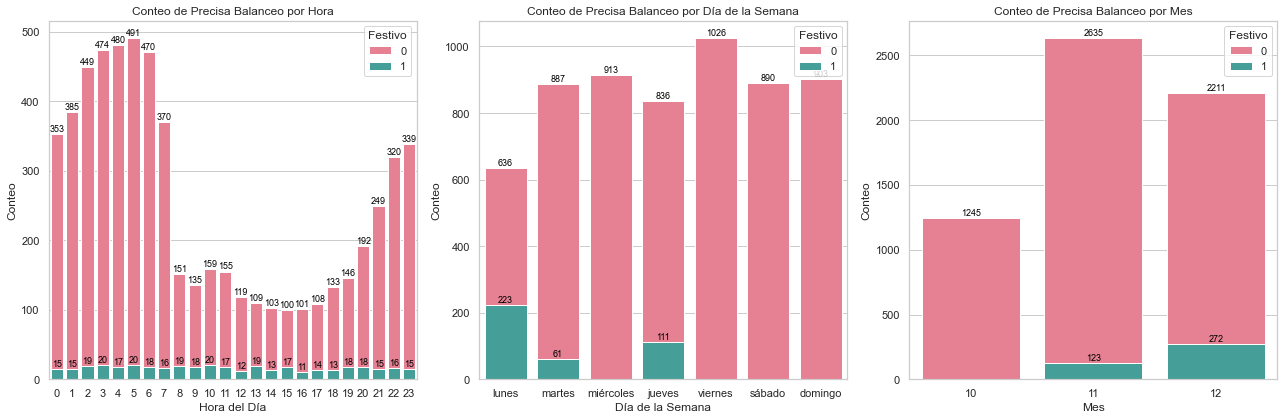

In [23]:
# Filter data where precisa_balanceo = True
df_true = df_route[df_route['precisa_balanceo'] == True]


# Plot the data
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# by hour
sns.countplot(x='hora', 
              hue='festivo_encoded', 
              data=df_true, 
              ax=axes[0], 
              palette='husl', 
              dodge=False)
axes[0].set_title('Conteo de Precisa Balanceo por Hora')
axes[0].set_xlabel('Hora del Día')
axes[0].set_ylabel('Conteo')
axes[0].legend(title='Festivo', loc='upper right')

# by weekday
sns.countplot(x='dia_semana', 
              hue='festivo_encoded', 
              data=df_true, 
              ax=axes[1], 
              palette='husl', 
              dodge=False, 
              order=['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo'])
axes[1].set_title('Conteo de Precisa Balanceo por Día de la Semana')
axes[1].set_xlabel('Día de la Semana')
axes[1].set_ylabel('Conteo')
axes[1].legend(title='Festivo', loc='upper right')

# by month
sns.countplot(x='mes', 
              hue='festivo_encoded', 
              data=df_true,
              ax=axes[2],
              palette='husl',
              dodge=False,)
axes[2].set_title('Conteo de Precisa Balanceo por Mes')
axes[2].set_xlabel('Mes')
axes[2].set_ylabel('Conteo')
axes[2].legend(title='Festivo', loc='upper right')

# settings on the plots
for ax in axes:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

De las tres visualizaciones anteriores, podemos deducir las siguientes conclusiones:

- Entre las 00:00 y las 07:00 se produce una alta concentración de desbalanceo en las estaciones. Esto puede deberse a las altas ocupaciones en los barrios "dormitorio" o la escasa disponibilidad en la zona nocturna los días de fin de semana. Haremos un estudio del número de viajes que se producen en cada hora, para ver si balanceando a primera hora de la noche y primera hora de la mañana podemos reducir el desbalanceo en esas horas.
- El segundo pico de desbalanceos se da a las 10:00. Esto puede deberse al aumento de movimientos en la zona de negocios de la ciudad desde los barrios residenciales.
- Por último, se produce otro aumento a partir de las 21:00.
- El día con mayor número de estaciones desbalanceadas es el viernes y el menor el lunes.
- Respecto a los meses, dado que tratamos con una serie temporal y hemos optado por predecir sobre el conjunto ordenado, vamos a limitarnos a seguir la misma estrategia para todos los meses del año ya que de octubre se tienen menos registros en el conjunto de test.

Veamos el comportamiento de la variable que cuenta el total de los viajes por horas.

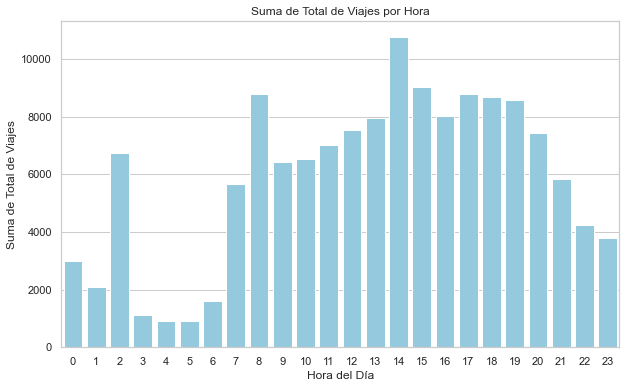

In [24]:
# Group by hour the total trips
hourly_total_trips = df_route.groupby('hora')['total_trips'].sum().reset_index()

# Plot the barchar
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Visualize the sum of total trips by hour
sns.barplot(x='hora', 
            y='total_trips', 
            data=hourly_total_trips,
            ax=ax, 
            color='skyblue')  # Color de las barras

ax.set_title('Suma de Total de Viajes por Hora')
ax.set_xlabel('Hora del Día')
ax.set_ylabel('Suma de Total de Viajes')
plt.show()


Concluimos que:

- Sorprendentemente, a las 2 de la mañana de produce un repunte de viajes que puede estar ocasionado por los fines de semana.
- A las 8 de la mañana aumenta la demanda que puede verse impactada por el aumento de estaciones desbalanceadas a las 7 de la mañana.
- El pico de viajes se produce a las 14:00. Sin embargo, entre las 10 y las 19, las estaciones parecen estar bien balanceadas.
- A partir de las 20:00 la demanda del servicio comienza a bajar, lo que explica que se pueda producir un aumento del desbalanceo.

Realizaremos el mismo estudio separando los distintos días de la semana para poder concluir las hipótesis.

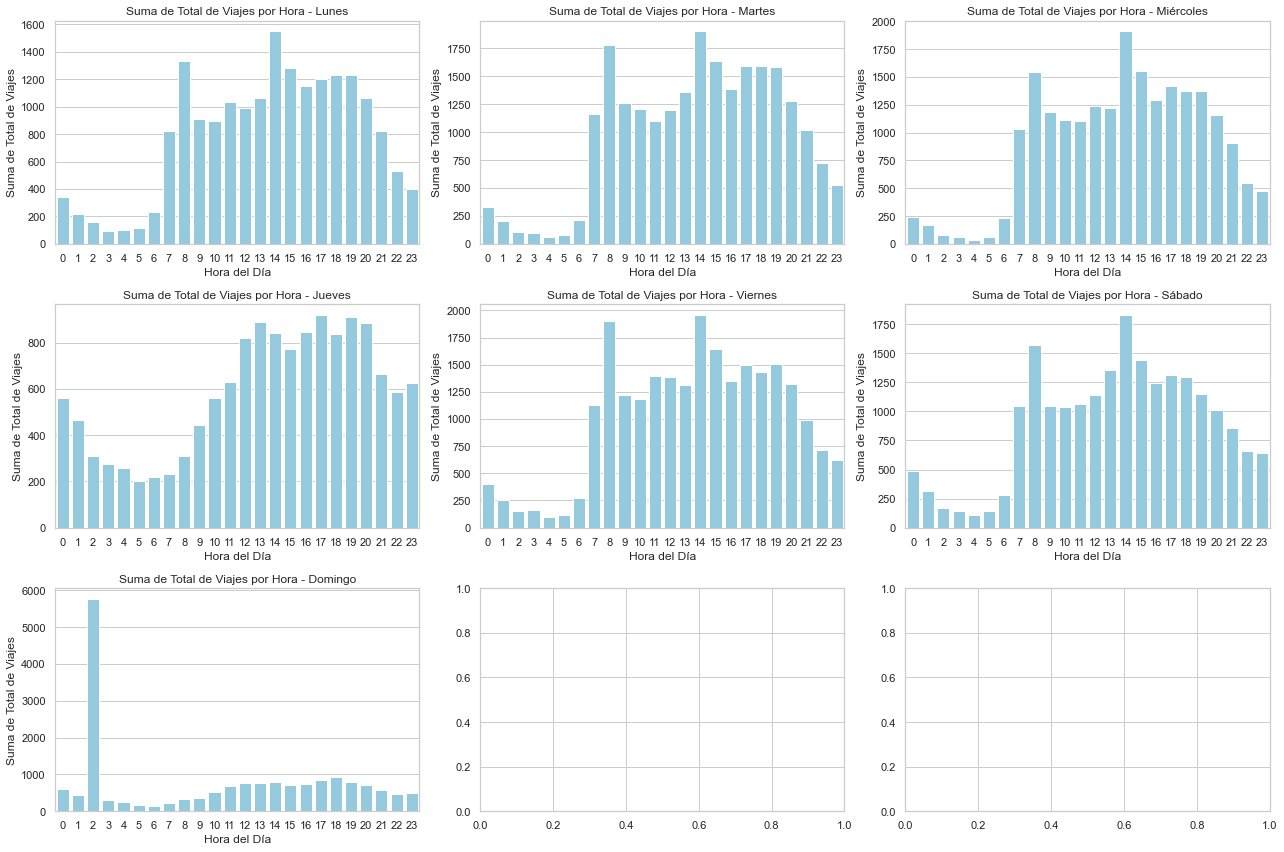

In [25]:
# plots by weekdays
dias_semana_unicos = sorted(df_route['dia_semana'].unique(), key=lambda x: ['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo'].index(x))


sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# iteartion for each weekday
for i, dia in enumerate(dias_semana_unicos):
    df_dia_semana = df_route[df_route['dia_semana'] == dia]
    hourly_total_trips = df_dia_semana.groupby('hora')['total_trips'].sum().reset_index()
    
    sns.barplot(x='hora', 
                y='total_trips', 
                data=hourly_total_trips,
                ax=axes[i//3, i%3],  # Usar los ejes correspondientes a la posición en la matriz de subtramas
                color='skyblue')  
    
    axes[i//3, i%3].set_title(f'Suma de Total de Viajes por Hora - {dia.capitalize()}')
    axes[i//3, i%3].set_xlabel('Hora del Día')
    axes[i//3, i%3].set_ylabel('Suma de Total de Viajes')


plt.tight_layout()
plt.show()

De los gráficos anteriores, concluimos que las horas que elegiremos para estudiar la optimización de la ruta son: 

- Lunes-Viernes: 00:00, 07:00, 10:00, 13:00, 17:00
- Sábados: 06:00, 12:00, 18:00, 23:00 
- Domingos: no se prestará el servicio de balanceo

Como queremos definir una ruta de reparto optimizada para casos concretos y que posteriormente esto se generalice a todo el sistema y todos los días, dado que no vamos a hacer una distinción por meses ni por número de día, vamos a tomar para cada día de la semana (excepto para el domingo), un día aleatorio en los horarios donde se hará el servicio de balanceo para poder establecer las distintas rutas de reparto optimizadas.

In [26]:
# Define a function to apply the schedule filter
def filter_schedule(row):
    if row['dia_semana'] in ['lunes', 'martes', 'miércoles', 'jueves', 'viernes']:
        return row['hora'] in [0, 7, 10, 13, 17]
    elif row['dia_semana'] == 'sábado':
        return row['hora'] in [6, 12, 18, 23]
    else:  # sunday
        return False  # No balance service on Sundays

# Apply the filter
df_route_filtered = df_true[df_true.apply(filter_schedule, axis=1)].sort_values(by=['mes','dia','hora','station_id'])

# Take first week for the balance optimization: 25-oct to 30-oct
df_enrutado = df_route_filtered.loc[(df_route_filtered['mes'] == 10) & (df_route_filtered['dia'] >= 25) & (df_route_filtered['dia'] <= 30)]

# Let's focus in case at least 5 stations need balance for the optimization
for dia_semana in df_enrutado['dia_semana'].unique():
    df_dia = df_enrutado[df_enrutado['dia_semana'] == dia_semana]
    
    # iteration over the hours in the day
    for hora in df_dia['hora'].unique():
        # filter data for the hour in the day
        df_hora = df_dia[df_dia['hora'] == hora]
        
        # number of rows in day and hour
        num_registros = len(df_hora)
        
        # keep the days with at least 5 stations for balancing
        if num_registros < 5:
             df_enrutado = df_enrutado.drop(df_hora.index)
df_enrutado   

,station_id,hora,dia,mes,festivo_encoded,total_trips,bike_stands,precisa_balanceo,bikes,lat,lng,precio_2022_euros_m2,close_green_area_shape,dia_semana
2257,14,0,25,10,0,1,20,True,1,39.468935,-0.379815,3417.0,862.400958,lunes
2247,40,0,25,10,0,1,26,True,0,39.470434,-0.374915,3417.0,1828.154105,lunes
2253,79,0,25,10,0,1,20,True,1,39.472747,-0.357333,2907.0,4774.289340,lunes
2246,92,0,25,10,0,5,20,True,2,39.475828,-0.356059,2907.0,1435.383720,lunes
2255,148,0,25,10,0,2,35,True,0,39.467113,-0.375469,2738.0,2478.634566,lunes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,50,7,30,10,0,1,40,True,2,39.453286,-0.352950,2638.0,6047.472401,jueves
4670,66,7,30,10,0,0,25,True,24,39.464239,-0.346352,1894.0,3815.673202,jueves
4657,101,7,30,10,0,1,30,True,29,39.470068,-0.334361,2094.0,246.516198,jueves
4669,110,7,30,10,0,1,30,True,1,39.480708,-0.336771,2566.0,700.942019,jueves


Una vez hemos filtrado el conjunto de datos por aquellos registros que en una hora y día determinado tiene al menos 5 estaciones que ser balanceadas vamos a desarrollar el algoritmo de optimización de la ruta para cada día de la semana con los horarios que necesitan el servicio de balanceo.

### 4.3 Optimización de la ruta de reparto. Algoritmo de Dijkstra: ruta más corta entre estaciones.

Para la optimización de la ruta de reparto, vamos a utilizar el algoritmo de Djikstra. El algoritmo de Dijkstra, también llamado algoritmo de caminos mínimos, es un algoritmo para la determinación del camino más corto, dado un vértice origen, hacia el resto de los vértices en un grafo que tiene pesos en cada arista [Wikipedia](https://es.wikipedia.org/wiki/Algoritmo_de_Dijkstra).

Para encontrar el punto de inicio del algoritmo, dado que queremos balancear las estaciones, ya sea por exceso de bicis o por ausencia de aparcamiento, en nuestro caso vamos a elegir la estación con menor número de bicicletas como punto inicial. Además, en caso de que haya varias estaciones con el mismo número mínimo de bicicletas, vamos a fijarnos en el precio del metro cuadrado del barrio donde se localiza la estación, para plantear así un proyecto a la empresa de Valenbisi de instalación de almacenes de bicicletas desde donde partirán los camiones cargados con bicicletas.

En el siguiente código vamos a definir la función que representa sobr eun mapa la ruta mínima empezando por la estación con menor número de bicicletas y en caso de empate, la estación situada en el barrio con menor precio por metro cuadrado. 

In [27]:
def visualize_optimal_route(df):
    """
    Visualizes the optimal bike balancing route on a map.

    Parameters:
    df (pandas.DataFrame): DataFrame with columns:
        - 'station_id': Unique identifier of the station.
        - 'lat': Latitude of the station.
        - 'lng': Longitude of the station.
        - 'precio_2022_euros_m2': Price per square meter in 2022.
        - 'bikes': Number of available bikes at the station.

    Returns:
    folium.Map: Folium object displaying the map with the optimal route.
    """
    # Create an undirected graph
    G = nx.Graph()

    # Add nodes to the graph and the map
    m = folium.Map(location=[df['lat'].mean(), df['lng'].mean()], zoom_start=13)
    
    # Add a tooltip with some info to each station
    for station_id, lat, lng, precio in zip(df['station_id'], df['lat'], df['lng'], df['precio_2022_euros_m2']):
        popup_html = f"<b>Station ID:</b> {station_id}<br><b>Precio por m²:</b> {precio} €/m²"
        folium.Marker([lat, lng], popup=popup_html).add_to(m)
    
    # Calculate the distance matrix
    coords = df[['lat', 'lng']].values
    dist_matrix = distance_matrix(coords, coords)
    
    # Add edges to the graph with their weights
    for i in range(len(df)):
        for j in range(len(df)):
            if i != j:
                G.add_edge(df.iloc[i]['station_id'], df.iloc[j]['station_id'], weight=dist_matrix[i][j])
    
    # Starting station based on bikes and m2 price
    start_station = df.loc[df['bikes'].idxmin()]
    if df['bikes'].value_counts().get(0, 0) > 1:
        start_station = df.loc[df['precio_2022_euros_m2'].idxmin()]
    
    # Initialize variables to keep track of visited stations and total distance
    visited_stations = set()
    total_distance = 0
    
    # Start from the starting station
    current_station = start_station['station_id']
    visited_stations.add(current_station)
    
    # Loop until all stations are visited
    while len(visited_stations) < len(df):
        # Find the nearest unvisited station
        nearest_station = None
        shortest_distance = float('inf')
        for station_id in df['station_id']:
            if station_id not in visited_stations:
                distance = nx.shortest_path_length(G, source=current_station, target=station_id, weight='weight')
                if distance < shortest_distance:
                    shortest_distance = distance
                    nearest_station = station_id
        
        # Update total distance and visited stations
        total_distance += shortest_distance
        visited_stations.add(nearest_station)
        
        # Paint the path on the map
        start_coords = df.loc[df['station_id'] == current_station, ['lat', 'lng']].values[0]
        end_coords = df.loc[df['station_id'] == nearest_station, ['lat', 'lng']].values[0]
        folium.PolyLine([start_coords, end_coords], color="red", weight=2.5, opacity=1).add_to(m)
        
        # Move to the nearest station
        current_station = nearest_station
    
    # Add extra info on the starting station
    start_coords = df.loc[df['station_id'] == start_station['station_id'], ['lat', 'lng']].values[0]
    popup_start = f"<b>Inicio</b><br><b>Station ID:</b> {start_station['station_id']}<br><b>Precio por m²:</b> {start_station['precio_2022_euros_m2']} €/m²"
    folium.Marker(start_coords, icon=folium.Icon(color='green'), popup=popup_start).add_to(m)
    
    return m

In [28]:
# Create the directory if it does not exist
carpeta_rutas_optimas = 'rutas_optimas'
if not os.path.exists(carpeta_rutas_optimas):
    os.makedirs(carpeta_rutas_optimas)

# Apply the function visualize_optimal_route for groups (weekday, hour) in df_enrutado
for (dia_semana, hora), group in df_enrutado.groupby(['dia_semana', 'hora']):
    mapa = visualize_optimal_route(group)
    
    # Save the html map with the weekday_hour name
    nombre_html = f"{dia_semana}_{hora}.html"
    ruta_html = os.path.join(carpeta_rutas_optimas, nombre_html)
    mapa.save(ruta_html)
    
    # Display the map
    titulo = f"Ruta de reparto óptima para el día de la semana: {dia_semana} a las {hora} horas"
    print(titulo)
    display(mapa)


Ruta de reparto óptima para el día de la semana: jueves a las 0 horas


Ruta de reparto óptima para el día de la semana: jueves a las 7 horas


Ruta de reparto óptima para el día de la semana: lunes a las 0 horas


Ruta de reparto óptima para el día de la semana: lunes a las 7 horas


Ruta de reparto óptima para el día de la semana: martes a las 0 horas


Ruta de reparto óptima para el día de la semana: martes a las 7 horas


Ruta de reparto óptima para el día de la semana: miércoles a las 0 horas


Ruta de reparto óptima para el día de la semana: miércoles a las 7 horas


Ruta de reparto óptima para el día de la semana: sábado a las 6 horas


Ruta de reparto óptima para el día de la semana: sábado a las 23 horas


Ruta de reparto óptima para el día de la semana: viernes a las 0 horas


Ruta de reparto óptima para el día de la semana: viernes a las 7 horas
